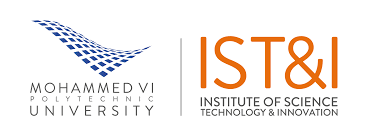

# $\textbf{Salary prediction using its description}$

In [44]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import time
import sys
from matplotlib.pylab import rcParams
import re
import gc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [45]:
import warnings
warnings.simplefilter('ignore')
font_axis = { 'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 14}
font_title = {'family': 'serif','color':  'black', 'weight': 'normal', 'size': 16}
plt.style.use('seaborn')
rcParams['figure.figsize'] = (13, 6)
rcParams['font.family'] = ['serif']

Data resource => https://www.kaggle.com/competitions/job-salary-prediction/data

In [46]:
df = pd.read_csv("Train_rev1.csv")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [48]:
df.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

### $\textbf{Remove covariates with more than 10% of missing, null values}$

In [49]:
columns_to_delete = df.columns[df.isnull().sum()/len(df)*100 > 10]
columns_to_delete

Index(['ContractType', 'ContractTime', 'Company'], dtype='object')

In [50]:
df.drop(columns_to_delete, axis=1, inplace=True)

In [51]:
df.isnull().sum()/len(df)*100

Id                    0.000000
Title                 0.000409
FullDescription       0.000000
LocationRaw           0.000000
LocationNormalized    0.000000
Category              0.000000
SalaryRaw             0.000000
SalaryNormalized      0.000000
SourceName            0.000409
dtype: float64

In [52]:
useful_columns = ['Title', 'FullDescription', 'Category', 'SalaryRaw', 'SalaryNormalized']

In [53]:
data = df[useful_columns][['FullDescription', 'SalaryNormalized']]

In [54]:
data
data.shape

(244768, 2)

In [55]:
data.isnull().sum()

FullDescription     0
SalaryNormalized    0
dtype: int64

In [56]:
data.isna().sum()

FullDescription     0
SalaryNormalized    0
dtype: int64

## $\textbf{Preprocessing the data}$

In [57]:
sum(data.duplicated()[data.duplicated() == True])

145

In [58]:
data.drop_duplicates(inplace=True)

In [59]:
sum(data.duplicated()[data.duplicated() == True])

0

In [60]:
data_no_duplicates = data.copy()

In [61]:
data_no_duplicates

,FullDescription,SalaryNormalized
0,Engineering Systems Analyst Dorking Surrey Sal...,25000
1,Stress Engineer Glasgow Salary **** to **** We...,30000
2,Mathematical Modeller / Simulation Analyst / O...,30000
3,Engineering Systems Analyst / Mathematical Mod...,27500
4,"Pioneer, Miser Engineering Systems Analyst Do...",25000
...,...,...
244763,Position: Qualified Teacher Subject/Specialism...,22800
244764,Position: Qualified Teacher or NQT Subject/Spe...,22800
244765,Position: Qualified Teacher Subject/Specialism...,22800
244766,Position: Qualified Teacher Subject/Specialism...,22800


In [62]:
model_data = data_no_duplicates.sample(10_000, random_state = 42) # Randomly selecting 5,000 samples from data

In [63]:
model_data.index = np.arange(len(model_data))

In [64]:
model_data

,FullDescription,SalaryNormalized
0,"Job Purpose: To use a range of commercial, cli...",60000
1,Development Manager C London to ****k Developm...,72500
2,Brief Outline A leading distributor and instal...,40000
3,Job Description The main duties are as follows...,34200
4,VSG are currently recruiting for professional ...,17280
...,...,...
9995,Jobcentreplus Including jobcentres and social ...,20000
9996,Bond Recruitment is the leading Estate agency ...,31500
9997,Must be age **** URGENT: Must be currently SI...,13920
9998,Experienced administration / clerical assistan...,13440


In [65]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    """"""
    
    sentence=str(sentence)
    sentence = sentence.lower()
    
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    
    rem_num = re.sub('[0-9]+', '', rem_url)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    
    #lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    
    return " ".join(filtered_words)

In [66]:
model_data['FullDescription_Clean'] = model_data['FullDescription'].map(lambda s:preprocess(s)) 

In [67]:
from nltk.tokenize import word_tokenize, sent_tokenize

def clean_text(article):
    sw = set(stopwords.words('english'))
    sw_addons = {"k", "uk","also"} 
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    output = ' '.join(output)
    return output

In [68]:
model_data['FullDescription_Clean'] = model_data['FullDescription_Clean'].map(lambda s:clean_text(s))

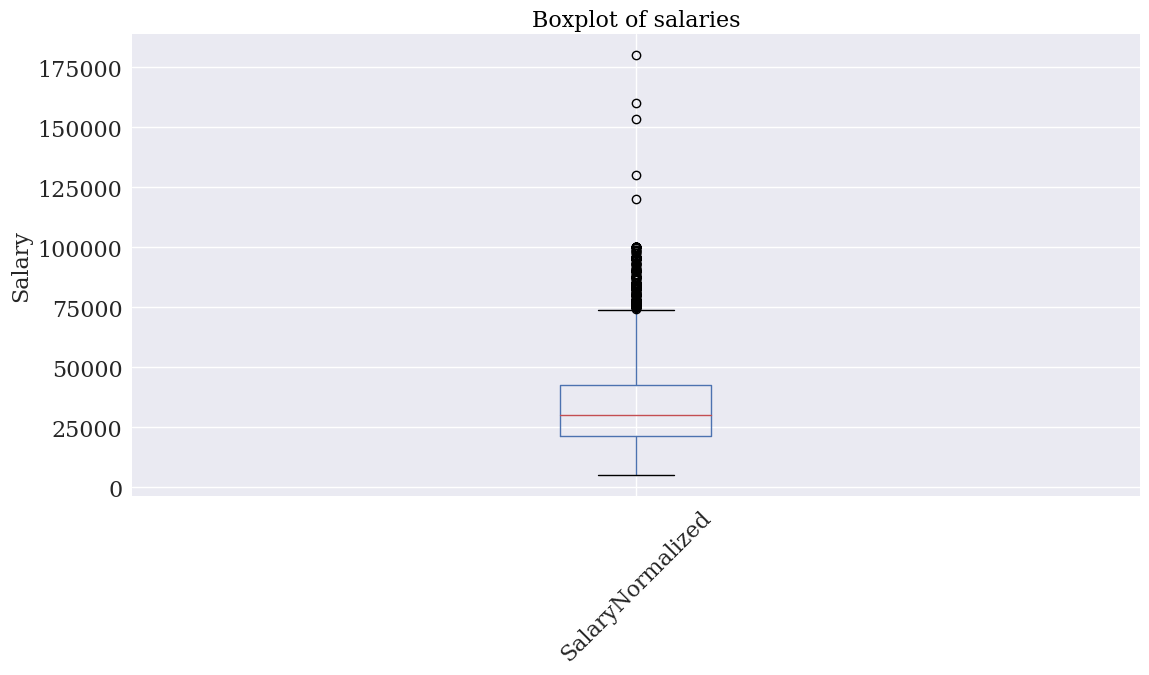

In [69]:
boxplot = model_data[['SalaryNormalized']].boxplot( figsize=(13, 6), rot=45, fontsize=16)
plt.title('Boxplot of salaries',fontdict=font_title)
plt.ylabel('Salary', fontsize=16)
plt.show()

In [70]:
model_data[['logged_salary']] = np.log(model_data[['SalaryNormalized']])

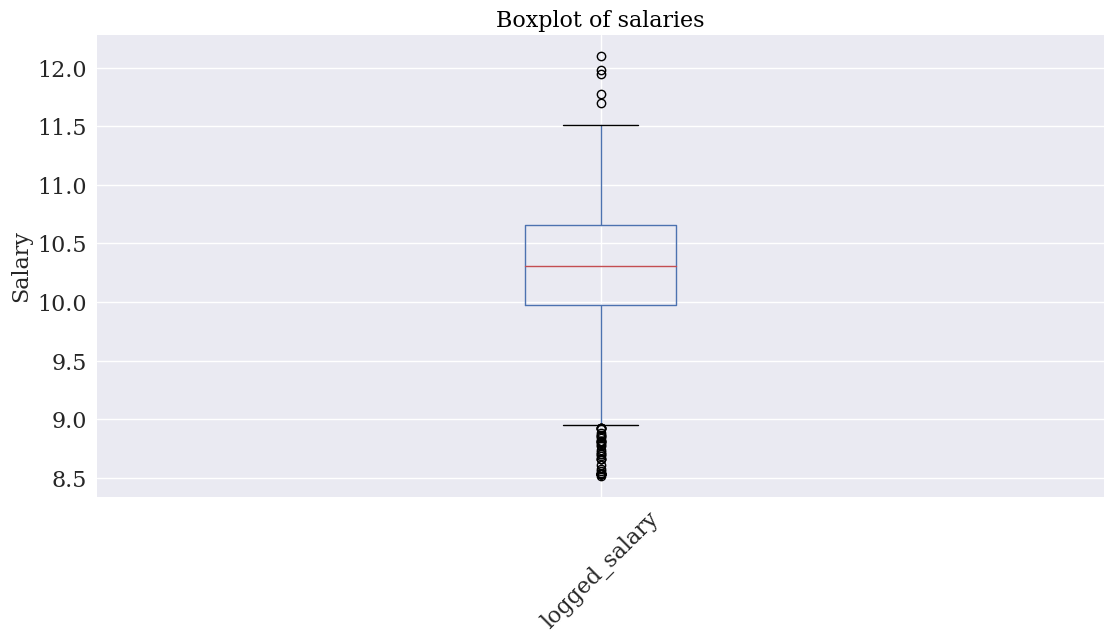

In [71]:
boxplot = model_data[['logged_salary']].boxplot( figsize=(13, 6), rot=45, fontsize=16)
plt.title('Boxplot of salaries',fontdict=font_title)
plt.ylabel('Salary', fontsize=16)
plt.show()

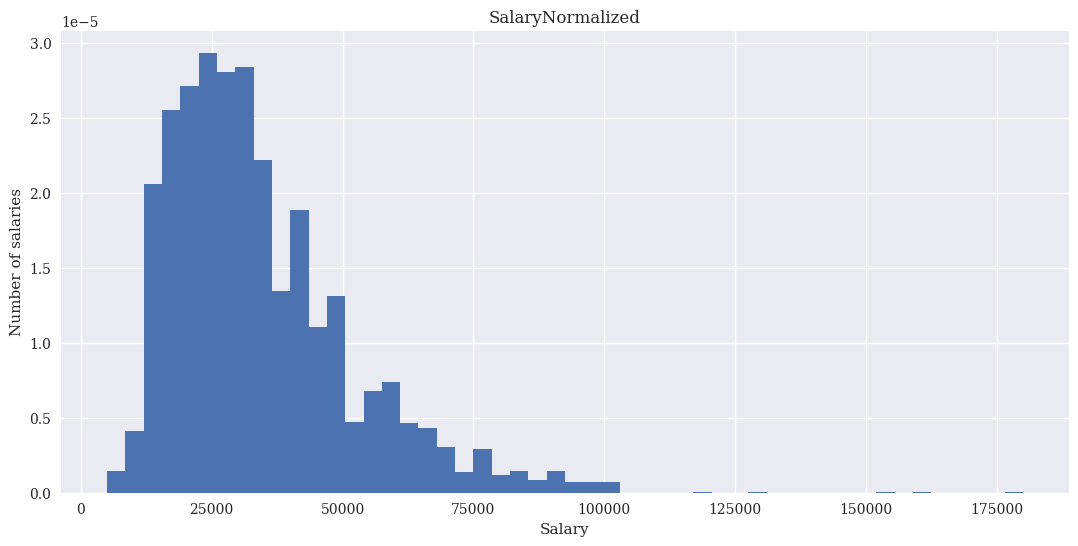

In [72]:
model_data[['SalaryNormalized']].hist(bins=50, density=True)
plt.ylabel('Number of salaries')
plt.xlabel('Salary')
plt.show()

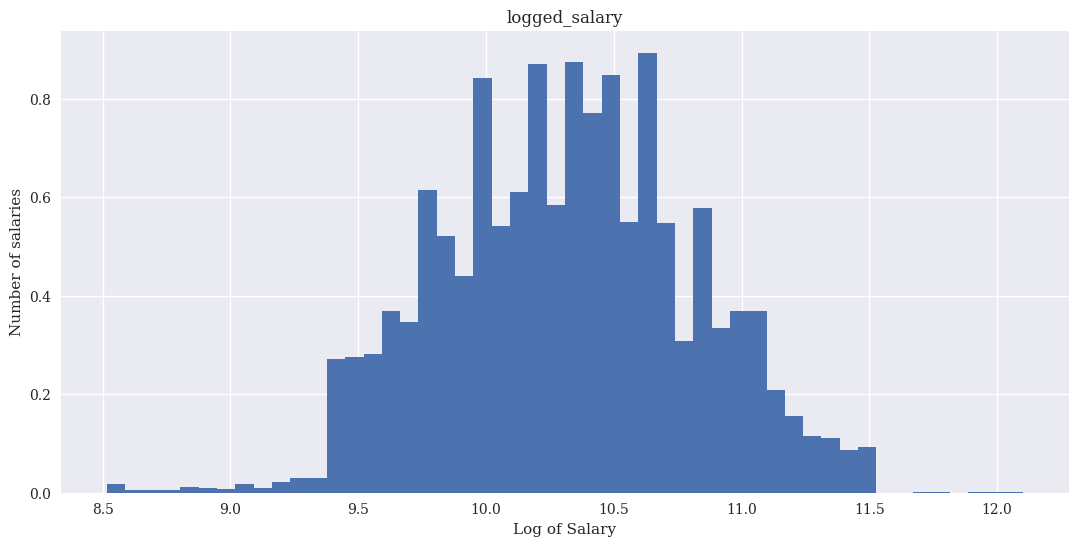

In [73]:
model_data[['logged_salary']].hist(bins=50, density=True)
plt.ylabel('Number of salaries')
plt.xlabel('Log of Salary')
plt.show()

## $\textbf{I - all-MiniLM-L6-v2 embedding}$ 

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2023-01-24 12:27:39.650537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 12:27:39.853391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 12:27:39.853416: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 12:27:40.779315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [75]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L12-v2')

In [76]:
y = model_data.SalaryNormalized
X_v2 = model.encode(model_data.FullDescription_Clean.values)

In [77]:
X_v2.shape

(10000, 384)

In [78]:
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [79]:
pd.DataFrame(data=X_v2)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.004268,0.015423,-0.032148,0.017984,0.034903,0.072520,0.017237,0.010423,-0.095502,-0.039370,...,0.045060,-0.032142,0.003331,-0.058082,-0.035970,-0.031329,-0.086099,0.023317,-0.005092,0.024524
1,-0.032015,0.047140,-0.008850,-0.008462,0.066533,-0.027259,-0.022643,-0.033234,-0.103277,-0.004619,...,0.051344,0.005411,0.021977,-0.064524,0.032445,0.063298,-0.029287,-0.051745,-0.001749,-0.014162
2,0.027028,-0.005152,0.020574,0.001236,-0.035677,0.027931,-0.005912,-0.119864,-0.087171,-0.039324,...,0.008322,-0.052992,0.012945,-0.012848,0.037773,-0.066922,-0.092677,0.001862,0.002999,0.027684
3,-0.049689,-0.012697,0.058191,-0.001166,0.064392,0.051660,-0.032301,-0.075209,-0.123369,0.025362,...,0.084701,-0.078645,0.029682,-0.058294,0.032831,-0.028514,-0.078773,-0.032091,0.036060,0.004079
4,0.023172,-0.012512,0.022662,-0.009924,0.058688,-0.016985,-0.050874,-0.097470,-0.079655,0.012495,...,0.061771,0.092243,-0.021548,0.038502,0.000524,-0.029324,-0.134504,0.010481,-0.024664,0.009118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.035547,-0.063832,0.004034,0.017270,0.027451,-0.016744,-0.012638,-0.038972,-0.105279,-0.009360,...,0.112833,-0.032781,0.065597,-0.033853,-0.090390,-0.047931,-0.055439,-0.008110,-0.015483,0.045766
9996,0.067276,0.031684,0.003002,0.020528,-0.048481,0.025229,0.003639,-0.030880,-0.077534,0.023066,...,0.023773,-0.001554,-0.028445,-0.000283,0.015068,0.007310,-0.086720,-0.055954,-0.007007,0.039362
9997,0.008483,0.038046,0.009545,0.030553,0.072367,0.041502,0.007087,-0.052148,-0.139335,0.000270,...,0.082479,0.062478,0.070047,-0.061264,-0.061054,0.027263,-0.078755,0.023438,-0.013166,-0.009793
9998,-0.080220,-0.000068,0.048700,0.035661,-0.045687,0.077356,0.003289,0.010850,-0.118727,-0.052228,...,0.044763,-0.003134,0.050278,-0.084841,-0.024247,0.028297,-0.039387,-0.003415,0.008971,0.027895


In [80]:
df_v2 = pd.DataFrame(data=X_v2)
df_v2

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.004268,0.015423,-0.032148,0.017984,0.034903,0.072520,0.017237,0.010423,-0.095502,-0.039370,...,0.045060,-0.032142,0.003331,-0.058082,-0.035970,-0.031329,-0.086099,0.023317,-0.005092,0.024524
1,-0.032015,0.047140,-0.008850,-0.008462,0.066533,-0.027259,-0.022643,-0.033234,-0.103277,-0.004619,...,0.051344,0.005411,0.021977,-0.064524,0.032445,0.063298,-0.029287,-0.051745,-0.001749,-0.014162
2,0.027028,-0.005152,0.020574,0.001236,-0.035677,0.027931,-0.005912,-0.119864,-0.087171,-0.039324,...,0.008322,-0.052992,0.012945,-0.012848,0.037773,-0.066922,-0.092677,0.001862,0.002999,0.027684
3,-0.049689,-0.012697,0.058191,-0.001166,0.064392,0.051660,-0.032301,-0.075209,-0.123369,0.025362,...,0.084701,-0.078645,0.029682,-0.058294,0.032831,-0.028514,-0.078773,-0.032091,0.036060,0.004079
4,0.023172,-0.012512,0.022662,-0.009924,0.058688,-0.016985,-0.050874,-0.097470,-0.079655,0.012495,...,0.061771,0.092243,-0.021548,0.038502,0.000524,-0.029324,-0.134504,0.010481,-0.024664,0.009118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.035547,-0.063832,0.004034,0.017270,0.027451,-0.016744,-0.012638,-0.038972,-0.105279,-0.009360,...,0.112833,-0.032781,0.065597,-0.033853,-0.090390,-0.047931,-0.055439,-0.008110,-0.015483,0.045766
9996,0.067276,0.031684,0.003002,0.020528,-0.048481,0.025229,0.003639,-0.030880,-0.077534,0.023066,...,0.023773,-0.001554,-0.028445,-0.000283,0.015068,0.007310,-0.086720,-0.055954,-0.007007,0.039362
9997,0.008483,0.038046,0.009545,0.030553,0.072367,0.041502,0.007087,-0.052148,-0.139335,0.000270,...,0.082479,0.062478,0.070047,-0.061264,-0.061054,0.027263,-0.078755,0.023438,-0.013166,-0.009793
9998,-0.080220,-0.000068,0.048700,0.035661,-0.045687,0.077356,0.003289,0.010850,-0.118727,-0.052228,...,0.044763,-0.003134,0.050278,-0.084841,-0.024247,0.028297,-0.039387,-0.003415,0.008971,0.027895


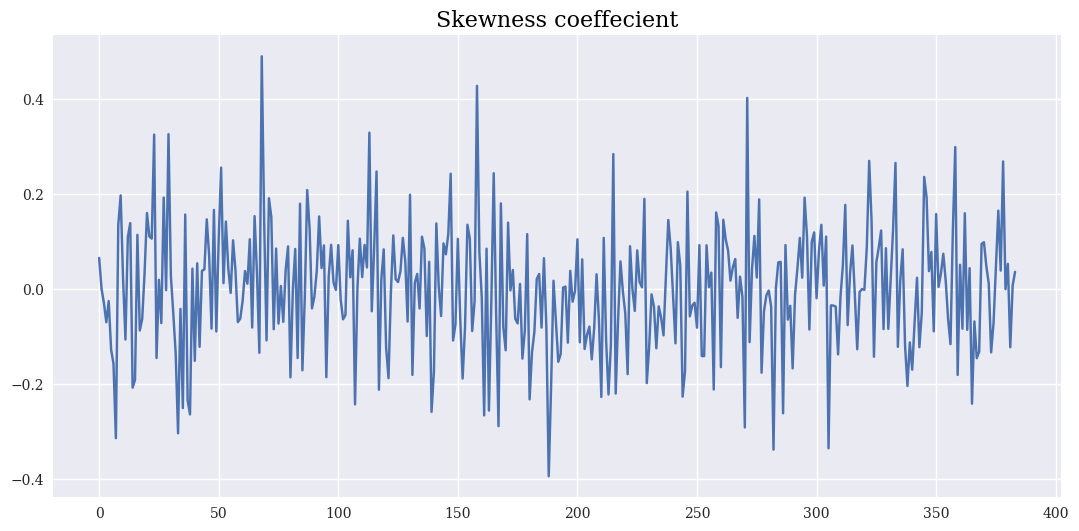

In [81]:
plt.plot(pd.DataFrame(df_v2.skew()))
plt.title('Skewness coeffecient', fontdict=font_title)
plt.show()

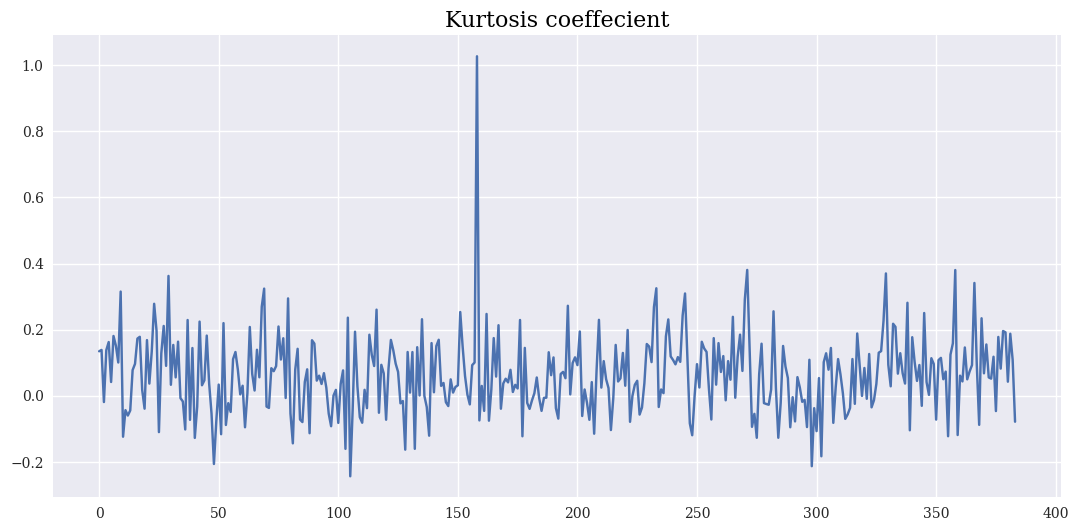

In [82]:
plt.plot(pd.DataFrame(df_v2.kurtosis()))
plt.title('Kurtosis coeffecient', fontdict=font_title)
plt.show()

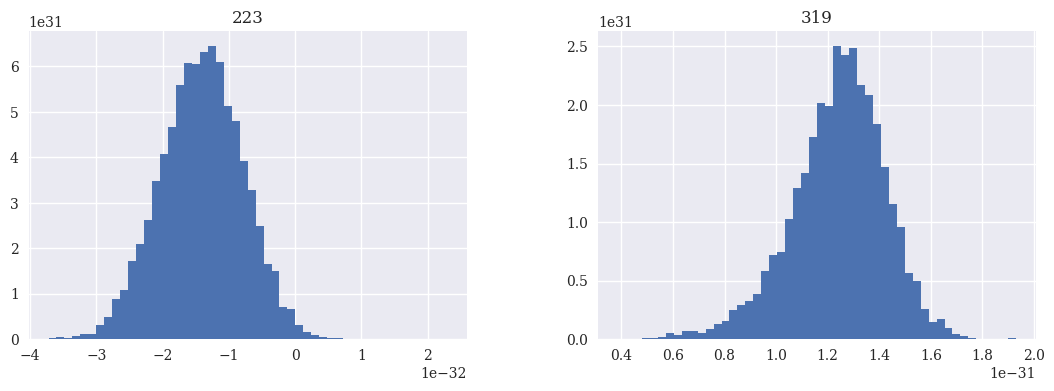

In [83]:
df_v2[df_v2.skew()[df_v2.skew() == 0].index].hist(bins=50, figsize=(13, 4),  density=True)
plt.show()

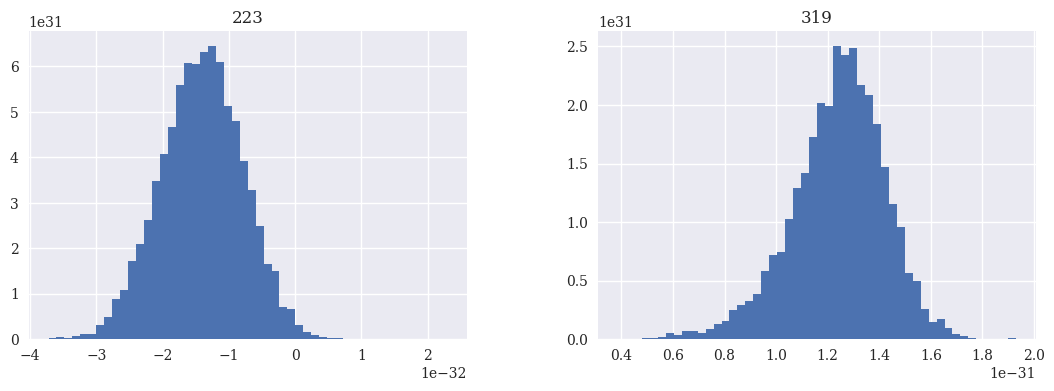

In [84]:
df_v2[df_v2.kurt()[df_v2.kurt() == 0].index].hist(bins=50, figsize=(13, 4),  density=True)
plt.show()

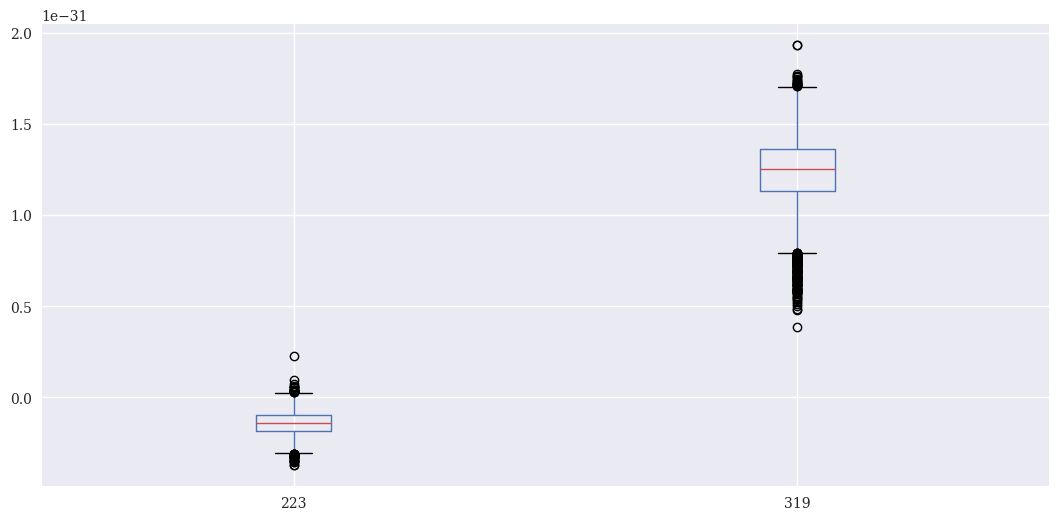

In [85]:
df_v2[df_v2.kurt()[df_v2.kurt() == 0.0].index].boxplot()
plt.show()

In [86]:
salaries = model_data[["SalaryNormalized", "logged_salary"]]
covariates_kurt = df_v2[df_v2.kurt()[df_v2.kurt() == 0.0].index]
df_kurt = pd.concat([covariates_kurt, salaries], axis=1)
df_kurt

,223,319,SalaryNormalized,logged_salary
0,-2.646836e-32,1.400006e-31,60000,11.002100
1,-1.153584e-32,9.939365e-32,72500,11.191342
2,-1.061422e-32,1.254660e-31,40000,10.596635
3,-2.329793e-32,1.351087e-31,34200,10.439981
4,-8.091544e-33,1.088548e-31,17280,9.757305
...,...,...,...,...
9995,-1.009686e-32,1.073144e-31,20000,9.903488
9996,-1.529493e-32,1.115757e-31,31500,10.357743
9997,-1.363482e-32,1.178156e-31,13920,9.541082
9998,-8.876494e-34,8.506434e-32,13440,9.505991


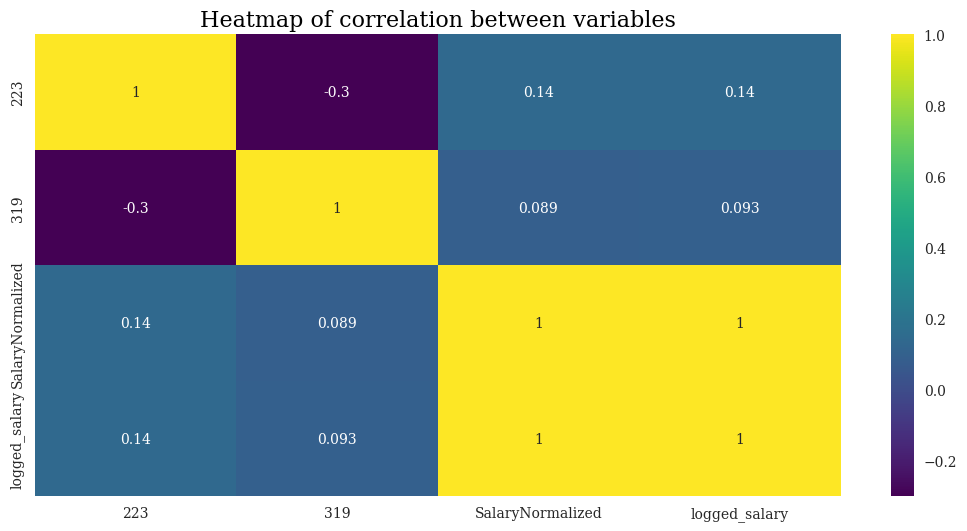

In [87]:
rcParams['figure.figsize'] = (13, 6)
sns.heatmap(np.log(df_kurt).corr(),annot=True,cmap='viridis')
plt.title('Heatmap of correlation between variables',fontdict=font_title)
plt.show()

In [88]:
df_kurt.columns

Index([223, 319, 'SalaryNormalized', 'logged_salary'], dtype='object')

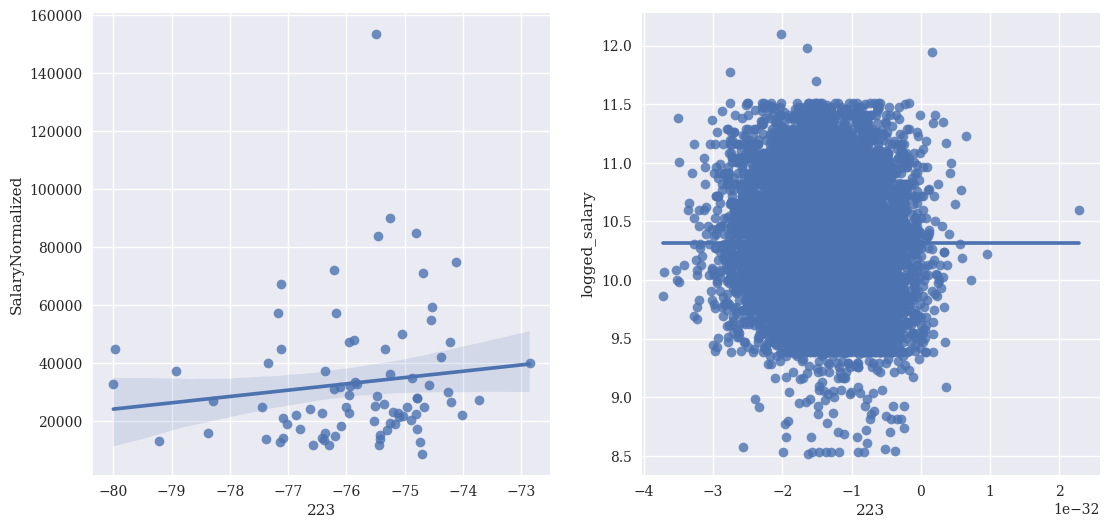

In [151]:
fig, axes = plt.subplots(1, 2)
sns.regplot(ax=axes[0], x=np.log(df_v2[223]), y=model_data.SalaryNormalized)
sns.regplot(ax=axes[1], x=(df_v2[223]), y=model_data.logged_salary)
plt.show()

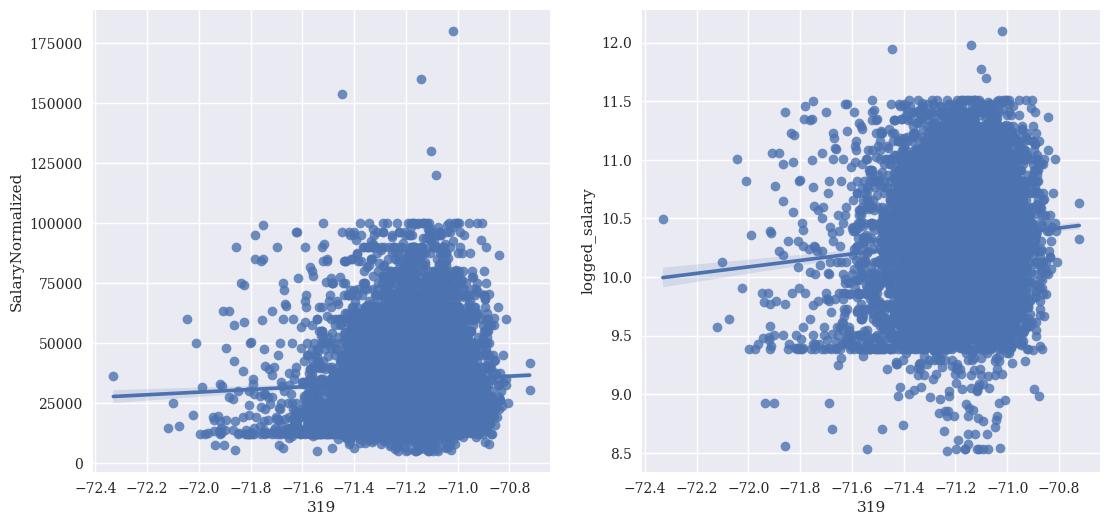

In [90]:
fig, axes = plt.subplots(1, 2)
sns.regplot(ax=axes[0], x=np.log(df_v2[319]), y=model_data.SalaryNormalized)
sns.regplot(ax=axes[1], x=np.log(df_v2[319]), y=model_data.logged_salary)
plt.show()

In [91]:
df_v2.describe()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.005732,0.019434,0.013259,0.018614,0.004666,0.011923,-0.009324,-0.022280,-0.100959,-0.031673,...,0.038251,-0.007524,-0.000081,-0.044529,-0.037897,-0.009382,-0.036354,-0.019302,0.006218,0.009308
std,0.033514,0.035971,0.041778,0.040423,0.038306,0.039242,0.033657,0.040066,0.037158,0.035169,...,0.034690,0.041790,0.036665,0.036749,0.041937,0.036693,0.037094,0.038898,0.035759,0.036716
min,-0.124331,-0.118132,-0.141560,-0.140768,-0.178284,-0.138367,-0.155558,-0.161865,-0.225574,-0.170118,...,-0.122752,-0.154309,-0.149802,-0.183313,-0.178604,-0.179941,-0.172070,-0.188812,-0.155793,-0.120260
25%,-0.028040,-0.004704,-0.014664,-0.008075,-0.020727,-0.013329,-0.031424,-0.046422,-0.126110,-0.055577,...,0.015740,-0.036079,-0.024968,-0.069608,-0.066507,-0.033603,-0.061781,-0.044453,-0.017774,-0.015745
50%,-0.005833,0.019775,0.013242,0.018632,0.004978,0.012692,-0.008309,-0.019759,-0.101481,-0.033074,...,0.038293,-0.007238,-0.001299,-0.044677,-0.039640,-0.009069,-0.036445,-0.018467,0.005899,0.009252
75%,0.016086,0.043487,0.041721,0.045361,0.030353,0.038829,0.013755,0.004926,-0.076649,-0.008714,...,0.061417,0.020518,0.023434,-0.020133,-0.012061,0.014702,-0.011737,0.006529,0.030607,0.034256
max,0.130687,0.167500,0.176467,0.157637,0.154449,0.159033,0.116398,0.126799,0.051657,0.149393,...,0.151977,0.165094,0.157185,0.099097,0.131118,0.164862,0.137580,0.116593,0.153728,0.158478


In [92]:
pd.concat([np.log(df_v2[223]), model_data.logged_salary], axis=1).corr()

,223,logged_salary
223,1.000000,0.139237
logged_salary,0.139237,1.000000


In [93]:
pd.concat([np.log(df_v2[223]), model_data.SalaryNormalized], axis=1).corr()

,223,SalaryNormalized
223,1.000000,0.127006
SalaryNormalized,0.127006,1.000000


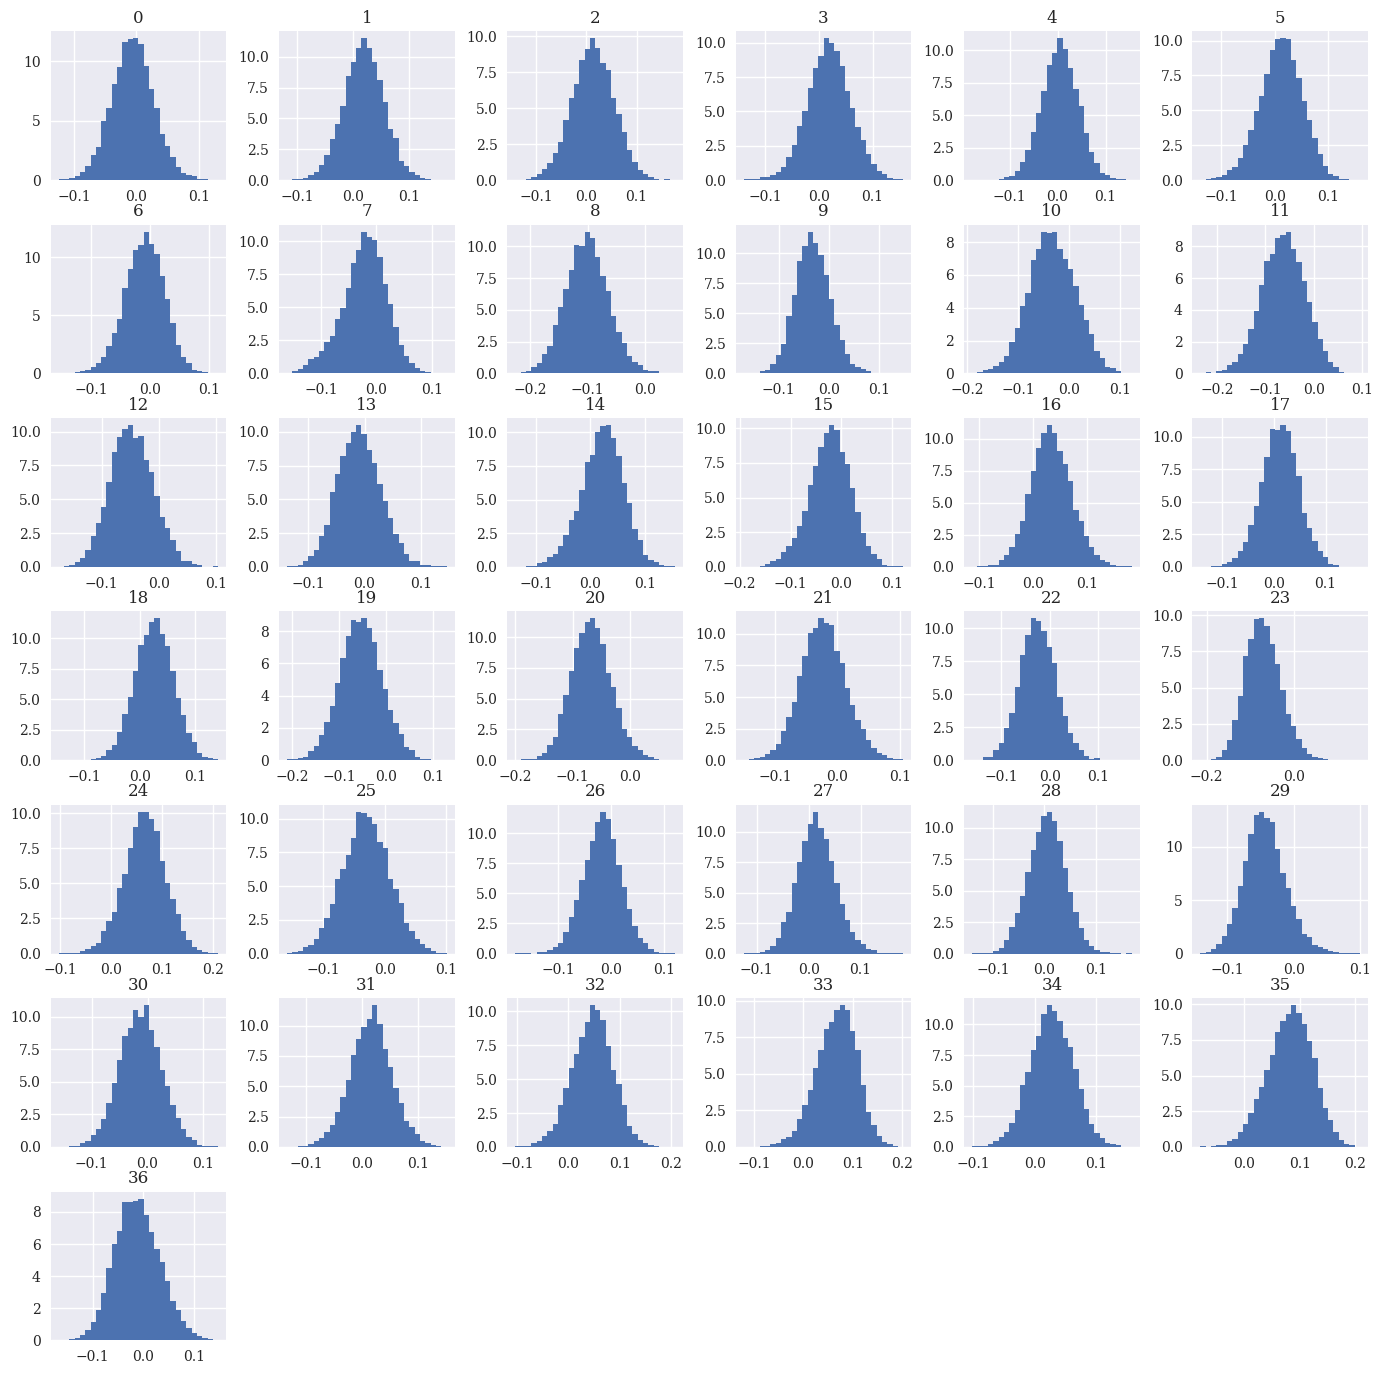

In [634]:
df_v2[np.arange(37)].hist(bins=30, figsize=(17, 17),  density=True)
plt.show()

### $\textbf{Yeo-Johnson transformation}$

In [868]:
import scipy.stats as stats
tmp = df_v2.copy()
cont_vars = np.arange(7)
for var in np.arange(7):

    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(df_v2[var])

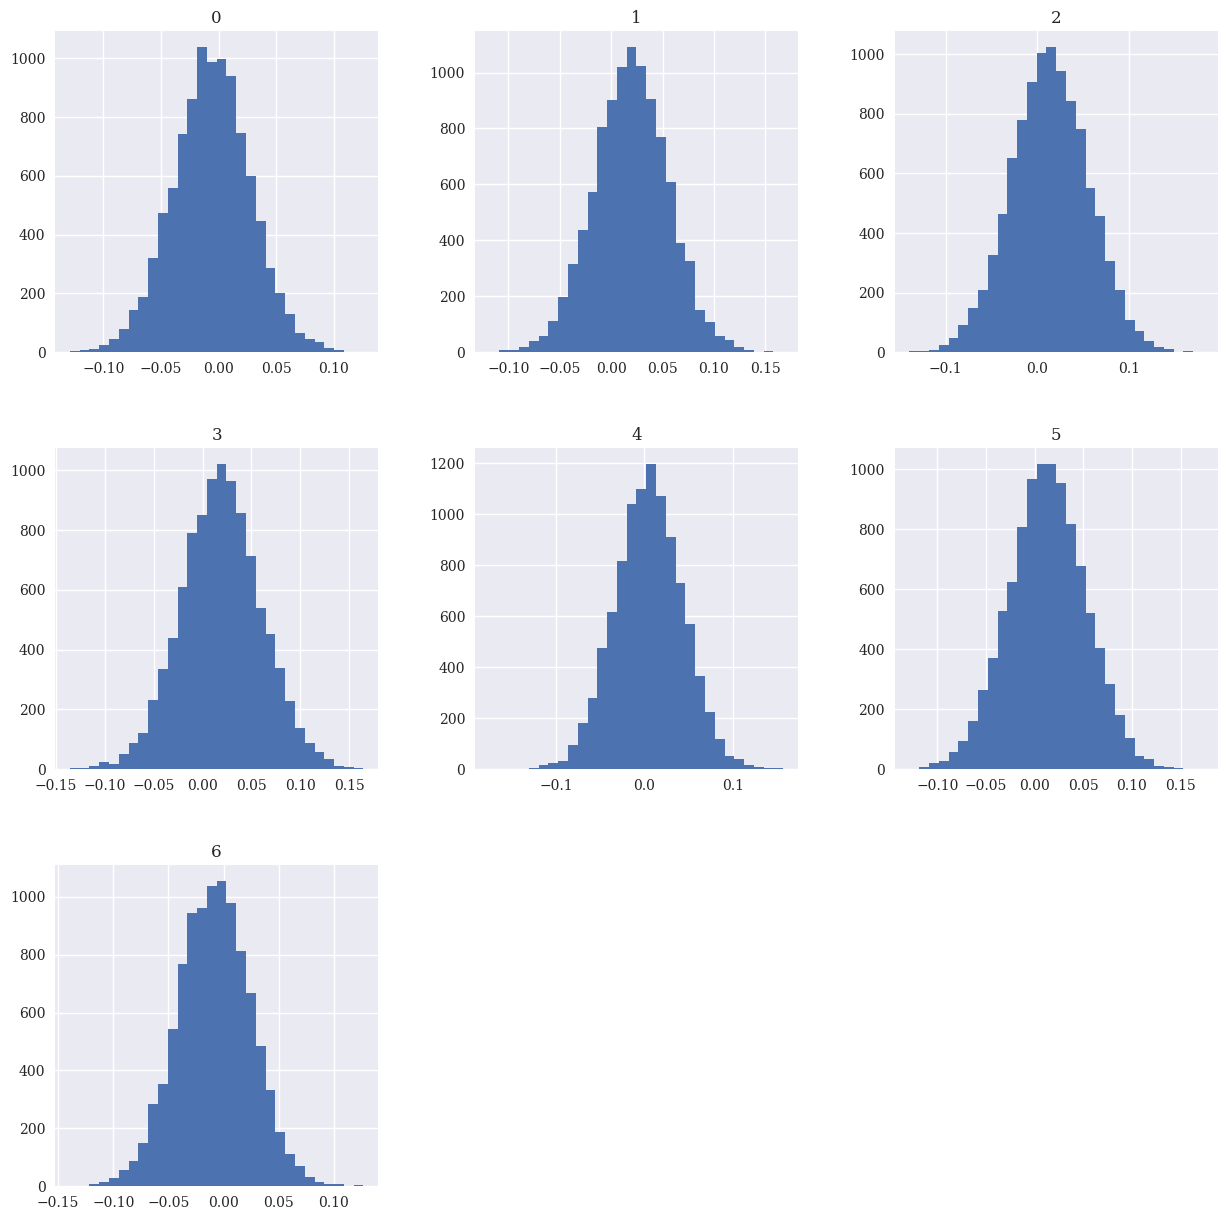

In [569]:
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

### $\textbf{Heatmap of correlation between variables}$

In [442]:
salary  = model_data[['SalaryNormalized']]
salary.index

Int64Index([ 52474,  40278,  57870,  22608, 103873, 213736, 176550, 106633,
             95289,   6641,
            ...
             73872, 192248,  27963, 244696,  87660,  44335,  24134, 237989,
             25774,  13238],
           dtype='int64', length=10000)

In [443]:
salary.index = df_v2[np.arange(1, 8)].index
salary.index

RangeIndex(start=0, stop=10000, step=1)

In [444]:
salary['salary'] = salary.SalaryNormalized

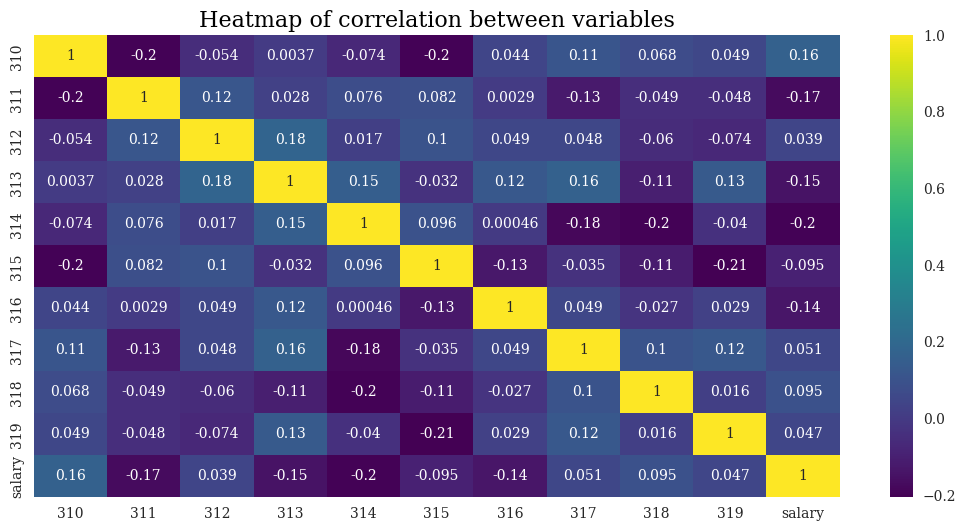

In [788]:
rcParams['figure.figsize'] = (13, 6)
sns.heatmap(pd.concat([df_v2[np.arange(310, 320)], salary.salary], axis=1).corr(),annot=True,cmap='viridis')
plt.title('Heatmap of correlation between variables',fontdict=font_title)
plt.show()

In [784]:
len(np.arange(300, 320))

20

In [446]:
df_v2.shape

(10000, 384)

In [878]:
y = model_data.SalaryNormalized.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(df_v2, y, test_size=0.33, random_state=47)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(X_train)
y_scaler.fit(y_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [879]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=17)

In [880]:
def neural_network(number_hidden_nodes=1024, number_input_columns=df.shape[1]):
    model = Sequential()
    
    # create the input latter
    model.add(Dense(units=number_hidden_nodes, input_dim = number_input_columns,
                         activation = "relu", kernel_initializer='uniform' ))
    # create hidden layer
    model.add(Dense(units=(number_hidden_nodes/2),  activation = "relu", kernel_initializer='uniform'))

    # 2nd hidden layer
    model.add(Dense(units=(number_hidden_nodes/4),  activation = "relu", kernel_initializer='uniform'))

    # create output layer
    model.add(Dense(units=1, activation = "linear", kernel_initializer='uniform'))

    # complie the NN and we can see how many total parameters along with how many parameters are in each layer
    model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
    model.summary()

    return model

In [881]:
nn_model_v2 = neural_network(number_input_columns=df_v2.shape[1])

nn_model_v2_history = nn_model_v2.fit(
    X_train_scaled, y_train_scaled, batch_size=128, validation_split=0.33, epochs=400, verbose=1,
    callbacks = callback
)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 1024)              394240    
                                                                 
 dense_145 (Dense)           (None, 512)               524800    
                                                                 
 dense_146 (Dense)           (None, 256)               131328    
                                                                 
 dense_147 (Dense)           (None, 1)                 257       
                                                                 
Total params: 1,050,625
Trainable params: 1,050,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
36/36 [==============================] - 1s 16ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0849 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0699
Epoch 2/400

Epoch 45/400
36/36 [==============================] - 0s 13ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0522 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0547
Epoch 46/400
36/36 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0529 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0652
Epoch 47/400
36/36 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0515 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0681
Epoch 48/400
36/36 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0519 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0777
Epoch 49/400
36/36 [==============================] - 0s 14ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0577 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0574
Epoch 50/400
36/36 [==============================] - 1s 16ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0510 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0549
Epoch 51/4

In [882]:
nn_model_v2.evaluate(X_test_scaled, y_test_scaled)

104/104 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0592


[0.006437945645302534, 0.006437945645302534, 0.05924870818853378]

In [884]:
predictions = nn_model_v2.predict(X_test_scaled)

salaries = pd.DataFrame({
    "Actual": y_scaler.inverse_transform(y_test_scaled).ravel(),
    "Predictions": y_scaler.inverse_transform(predictions).ravel()
})
salaries.head(10)

104/104 [==============================] - 0s 2ms/step


,Actual,Predictions
0,62499.0,60907.738281
1,75000.0,55884.332031
2,60000.0,77711.789062
3,50000.0,51670.574219
4,27000.0,23315.601562
5,20000.0,65024.144531
6,45000.0,56985.449219
7,18544.0,16044.290039
8,22500.0,40570.773438
9,55000.0,69730.632812


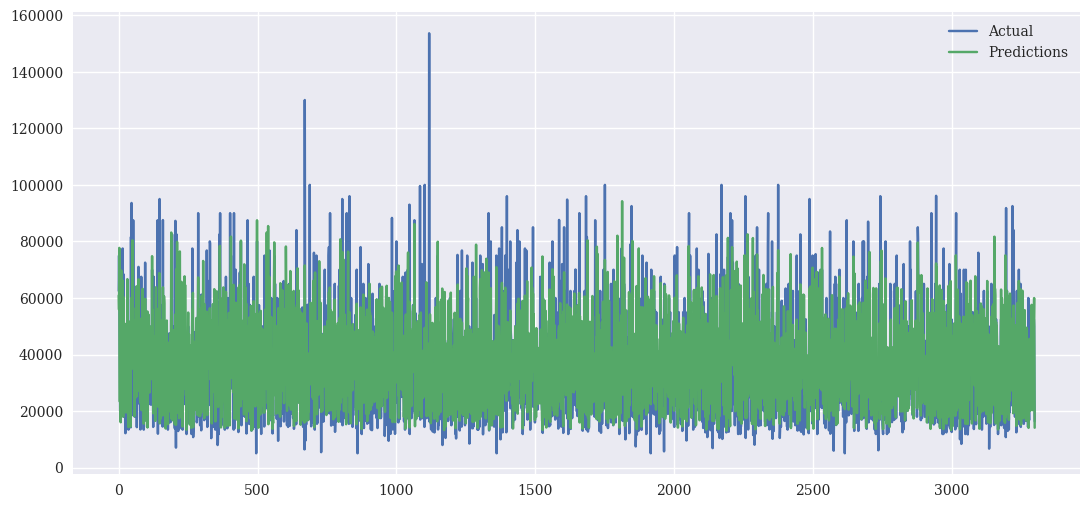

In [885]:
salaries.plot()
plt.savefig('v2_prediction_real.png')
plt.show()

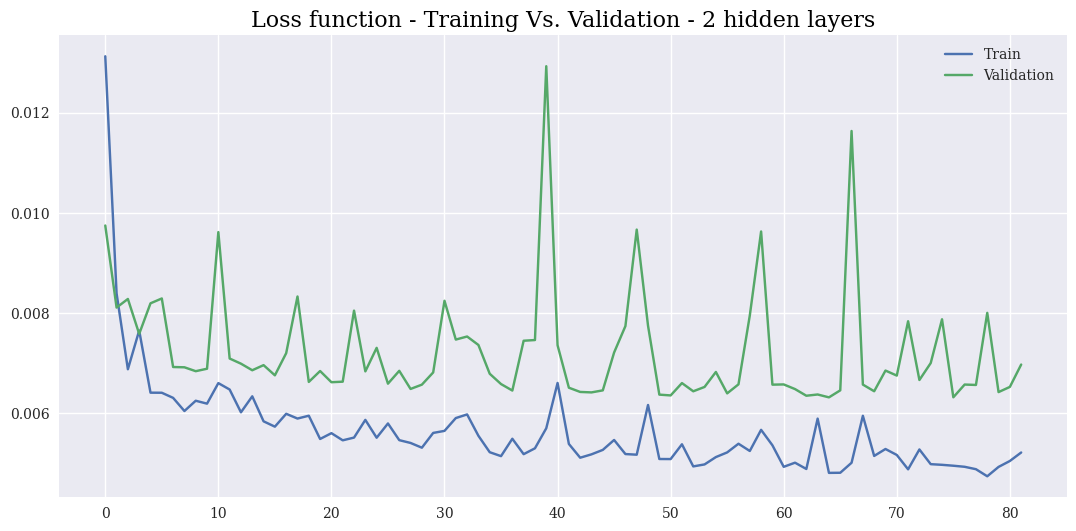

In [886]:
plt.plot(nn_model_v2_history.history["loss"])
plt.plot(nn_model_v2_history.history["val_loss"])
plt.title("Loss function - Training Vs. Validation - 2 hidden layers", fontdict=font_title)
plt.legend(["Train", "Validation"])
plt.savefig('v2_loss_mse.png')
plt.show()
plt.close()

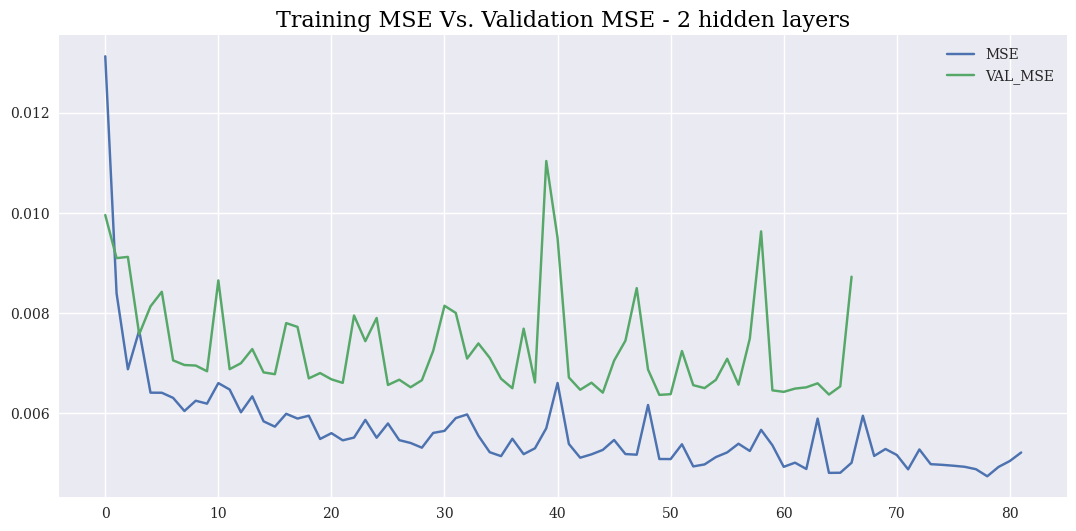

In [887]:
plt.plot(nn_model_v2_history.history["mse"])
plt.plot(nn_model_history.history["val_mse"])
plt.title("Training MSE Vs. Validation MSE - 2 hidden layers", fontdict=font_title)
plt.legend(["MSE", "VAL_MSE"])
plt.savefig('v2_mse_val_mse.png')
plt.show()
plt.close()

In [890]:
r2_test = sklearn.metrics.r2_score(salaries.Actual.values, salaries.Predictions.values)
r2_mse = sklearn.metrics.r2_score(
    y_scaler.inverse_transform(y_train_scaled),
    y_scaler.inverse_transform(nn_model_v2.predict(X_train_scaled))
)
print(f"Train R2 => {r2_mse}, Test R2 => {r2_test}")

210/210 [==============================] - 0s 2ms/step
Train R2 => 0.41376339722050237, Test R2 => 0.34887487684530927


## $\textbf{I-1 - all-MiniLM-L6-v2 embedding PCA}$ 

In [891]:
from sklearn.decomposition import PCA
pca_salary = PCA(n_components=50)
principalComponents = pca_salary.fit_transform(df_v2.values)
pd.DataFrame(principalComponents).index

d2 = model_data[['SalaryNormalized']]
d2.index = pd.DataFrame(principalComponents).index
df_v2_pca = pd.concat([pd.DataFrame(principalComponents), d2], axis=1)
df_v2_pca

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,SalaryNormalized
0,-0.344113,-0.202190,0.051815,-0.080023,-0.003293,0.018686,-0.056301,0.097281,-0.036989,-0.055650,...,0.082314,-0.010775,-0.005287,-0.042385,-0.017746,0.025362,-0.011954,0.011475,-0.034324,60000
1,-0.279273,0.126638,-0.212639,-0.101837,0.128474,-0.001296,-0.095100,-0.088510,-0.151538,-0.012423,...,0.008117,0.050645,-0.032248,-0.074845,0.064326,0.101288,-0.034184,0.014464,-0.058465,72500
2,-0.146847,-0.176190,0.028914,0.252194,0.103312,-0.037754,-0.006221,0.081849,0.269526,0.035890,...,-0.018352,-0.018247,-0.044887,0.036598,-0.044384,-0.004019,-0.004843,-0.031987,0.004092,40000
3,0.234323,-0.098911,-0.018364,-0.133238,0.247455,-0.361091,0.007757,-0.012508,-0.115296,-0.032763,...,0.027063,-0.024506,-0.054276,0.020048,-0.029502,0.081382,0.011091,0.032015,-0.043005,34200
4,0.023250,0.137513,0.003981,-0.095192,-0.026321,-0.085061,0.062059,-0.002675,0.118769,0.114780,...,-0.025496,0.034618,-0.066914,-0.002937,-0.054619,-0.008017,0.058820,-0.079866,-0.024393,17280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.183124,0.120209,-0.053813,-0.085043,-0.151039,-0.170209,-0.195696,-0.014879,0.028924,-0.073085,...,0.072334,-0.105691,-0.039853,-0.140540,-0.034937,0.052690,0.008114,0.011714,-0.003339,20000
9996,-0.035810,-0.025048,-0.213761,0.011130,-0.196892,0.010512,0.218920,-0.038544,-0.004687,-0.042506,...,0.018735,0.049696,0.017718,0.001662,-0.020823,0.066476,0.009776,-0.008664,0.114283,31500
9997,0.229467,0.085409,0.102670,-0.114848,-0.007383,-0.177567,-0.108461,0.045175,0.035619,0.039345,...,-0.090717,0.003715,0.088826,-0.108449,0.086479,-0.001889,0.007790,-0.134816,0.010099,13920
9998,0.125080,-0.011503,0.046598,-0.129995,-0.131889,-0.187281,-0.237414,0.008645,0.060505,0.005561,...,-0.023137,-0.050810,0.117727,-0.012961,-0.025607,-0.024611,-0.129316,0.032606,0.015356,13440


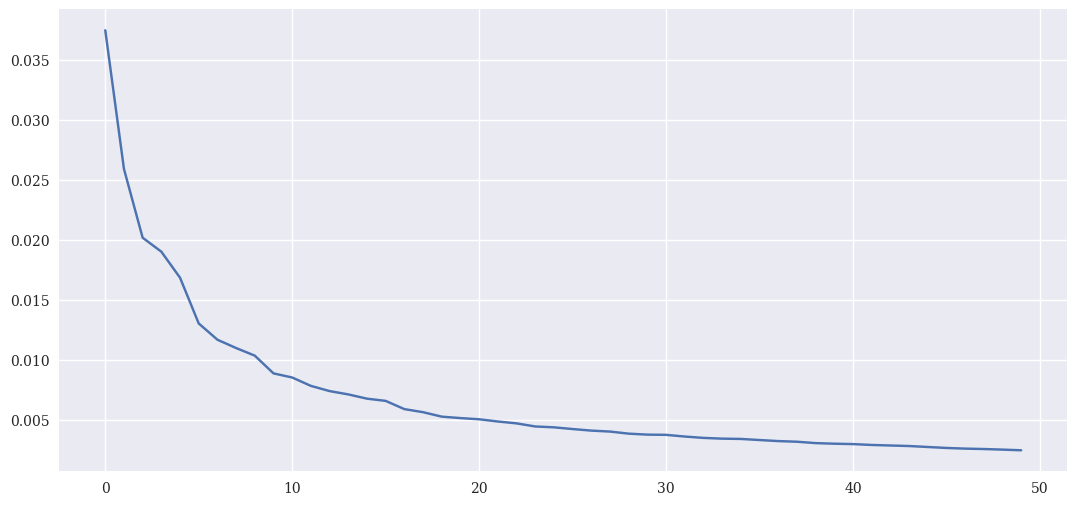

In [892]:
plt.plot(pca_salary.explained_variance_)
plt.show()

In [893]:
y = model_data.SalaryNormalized.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(df_v2_pca[np.arange(50)], y, test_size=0.33, random_state=47)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(X_train)
y_scaler.fit(y_train)

X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [894]:
nn_model_v2_pca = neural_network(number_input_columns=df_v2_pca.shape[1]-1)

nn_model_v2_pca_history = nn_model_v2_pca.fit(
    X_train_scaled, y_train_scaled, batch_size=128, validation_split=0.33, epochs=400, verbose=1,
    callbacks = callback
)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 1024)              52224     
                                                                 
 dense_149 (Dense)           (None, 512)               524800    
                                                                 
 dense_150 (Dense)           (None, 256)               131328    
                                                                 
 dense_151 (Dense)           (None, 1)                 257       
                                                                 
Total params: 708,609
Trainable params: 708,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
36/36 [==============================] - 1s 14ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0771 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0661
Epoch 2/400
36/

Epoch 45/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0534 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0582
Epoch 46/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0534 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0617
Epoch 47/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0532 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0569
Epoch 48/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0526 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0726
Epoch 49/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0557 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0564
Epoch 50/400
36/36 [==============================] - 0s 10ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0520 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0562
Epoch 51/4

In [895]:
predictions = nn_model_v2_pca.predict(X_test_scaled)

predicted_salaries = y_scaler.inverse_transform(predictions)
real_salaries = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

salaries = pd.DataFrame({
    "Real": real_salaries.ravel(),
    "Predicted": predicted_salaries.ravel()
})
salaries.head(10)

104/104 [==============================] - 0s 2ms/step


,Real,Predicted
0,62499.0,49654.847656
1,75000.0,48124.675781
2,60000.0,60689.886719
3,50000.0,30105.693359
4,27000.0,33864.707031
5,20000.0,36917.507812
6,45000.0,42668.648438
7,18544.0,14593.708984
8,22500.0,42465.890625
9,55000.0,46794.085938


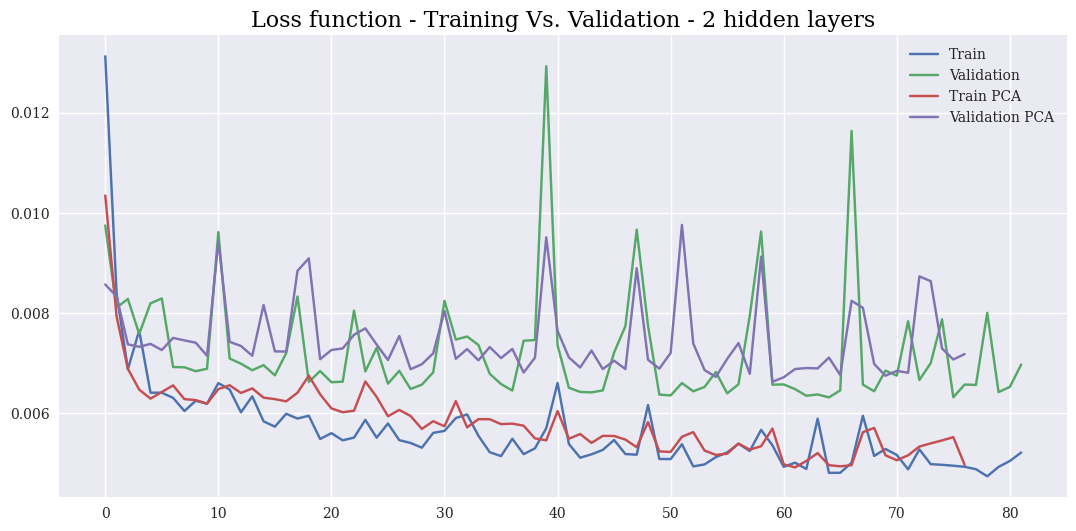

In [899]:
plt.plot(nn_model_v2_history.history["loss"], label="Train")
plt.plot(nn_model_v2_history.history["val_loss"], label="Validation")

plt.plot(nn_model_v2_pca_history.history["loss"], label="Train PCA")
plt.plot(nn_model_v2_pca_history.history["val_loss"], label="Validation PCA")

plt.title("Loss function - Training Vs. Validation - 2 hidden layers", fontdict=font_title)
plt.savefig('v2_loss_no_with_pca.png')
plt.legend()
plt.show()
plt.close()

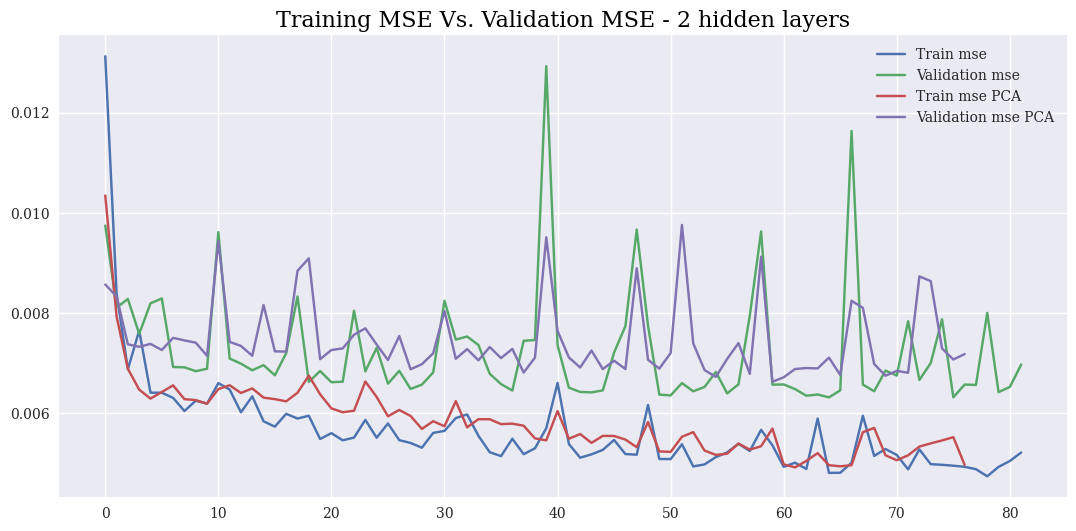

In [900]:
plt.plot(nn_model_v2_history.history["mse"], label="Train mse")
plt.plot(nn_model_v2_history.history["val_mse"], label="Validation mse")

plt.plot(nn_model_v2_pca_history.history["mse"], label="Train mse PCA")
plt.plot(nn_model_v2_pca_history.history["val_mse"], label="Validation mse PCA")

plt.title("Training MSE Vs. Validation MSE - 2 hidden layers", fontdict=font_title)
plt.savefig('v2_mse_no_with_pca.png')
plt.legend()
plt.show()
plt.close()

In [901]:
import sklearn
r2_test = sklearn.metrics.r2_score(salaries.Real.values, salaries.Predicted.values)
r2_mse = sklearn.metrics.r2_score(
    y_scaler.inverse_transform(y_train_scaled),
    y_scaler.inverse_transform(nn_model_tfid.predict(X_train_scaled))
)
print(f"Train R2 => {r2_mse}, Test R2 => {r2_test}")

210/210 [==============================] - 0s 2ms/step
Train R2 => -1.0484878858637003, Test R2 => 0.31964849861312483


## $\textbf{II - TfidfVectorizer}$

In [94]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/alain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alain/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(model_data.FullDescription_Clean).toarray()

In [97]:
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
X = X_tfidf

In [98]:
X.shape

(10000, 31141)

In [99]:
from sklearn.decomposition import PCA
pca_salary_tfid = PCA(n_components=50)
principalComponents = pca_salary_tfid.fit_transform(X)

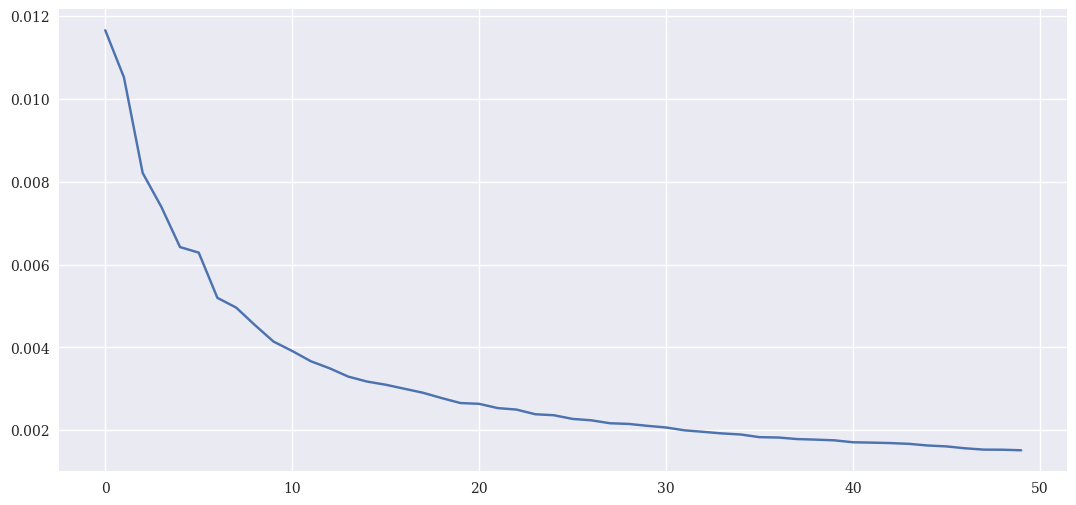

In [100]:
plt.plot(pca_salary_tfid.explained_variance_)
plt.show()

In [102]:
principal_df = pd.DataFrame(data = principalComponents)
X = principal_df.values
X.shape

(10000, 50)

In [ ]:
y = model_data.SalaryNormalized.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(X_train)
y_scaler.fit(y_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled =y_scaler.transform(y_test)

In [ ]:
nn_model_tfid = neural_network(number_input_columns=df_v2_pca.shape[1]-1)

nn_model_tfid_history = nn_model_tfid.fit(
    X_train_scaled, y_train_scaled, batch_size=128, validation_split=0.33, epochs=400, verbose=1,
    callbacks = callback
)

In [ ]:
nn_model_tfid.evaluate(X_test_scaled, y_test_scaled)

In [512]:
predictions = nn_model_tfid.predict(X_test_scaled)

predicted_salaries = y_scaler.inverse_transform(predictions)
real_salaries = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

salaries = pd.DataFrame({
    "Real": real_salaries.ravel(),
    "Predicted": predicted_salaries.ravel()
})
salaries.head()

104/104 [==============================] - 0s 2ms/step


,Real,Predicted
0,62499.0,56358.992188
1,75000.0,50516.425781
2,60000.0,64620.378906
3,50000.0,53168.449219
4,27000.0,37322.117188


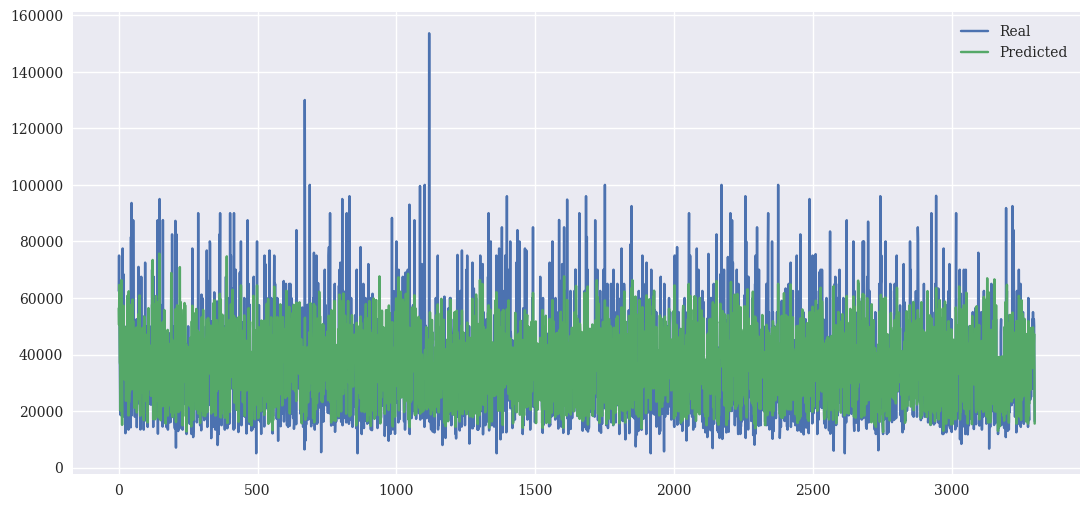

In [513]:
salaries.plot()
plt.savefig('tfidf_prediction_real.png')
plt.show()

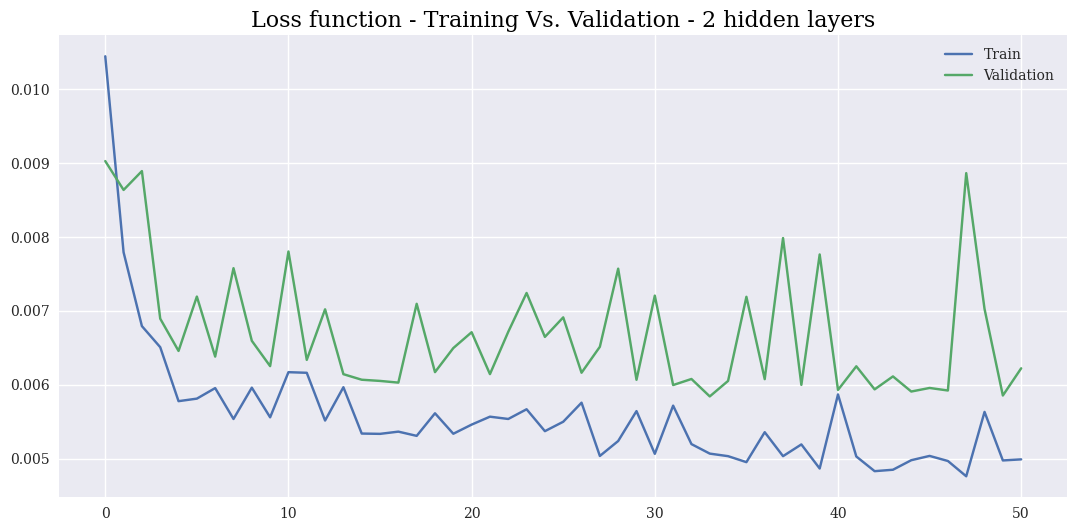

In [518]:
plt.plot(nn_model_tfid_history.history["loss"])
plt.plot(nn_model_tfid_history.history["val_loss"])
plt.title("Loss function - Training Vs. Validation - 2 hidden layers", fontdict=font_title)
plt.legend(["Train", "Validation"])
plt.savefig('tfidf_loss.png')
plt.show()
plt.close()

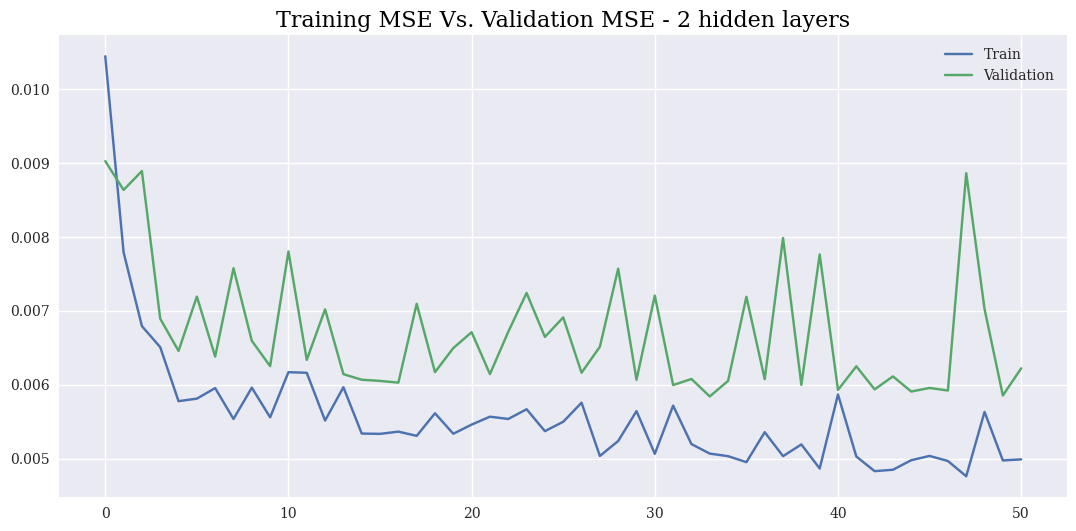

In [519]:
plt.plot(nn_model_tfid_history.history["mse"])
plt.plot(nn_model_tfid_history.history["val_mse"])
plt.title("Training MSE Vs. Validation MSE - 2 hidden layers", fontdict=font_title)
plt.legend(["Train", "Validation"])
plt.savefig('tfidf_mse.png')
plt.show()
plt.close()

In [533]:
import sklearn
r2_test = sklearn.metrics.r2_score(salaries.Real.values, salaries.Predicted.values)
r2_mse = sklearn.metrics.r2_score(
    y_scaler.inverse_transform(y_train_scaled),
    y_scaler.inverse_transform(nn_model_tfid.predict(X_train_scaled))
)
print(f"Train R2 => {r2_mse}, Test R2 => {r2_test}")

210/210 [==============================] - 0s 2ms/step
Train R2 => 0.43787334060822536, Test R2 => 0.42957477000428934


## $\textbf{Sklearn pipeline}$

In [293]:
# Create a pipeline that standardizes the data then creates a model
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.linear_model as lr
from sklearn.tree import DecisionTreeRegressor

In [308]:
# create pipeline
pipe_items = []
pipe_items.append(('standardize', MinMaxScaler()))
pipe_items.append(('lr', lr.LinearRegression()))
pipeline = Pipeline(pipe_items)
# evaluate pipeline

In [309]:
pipeline

Pipeline(steps=[('standardize', MinMaxScaler()), ('lr', LinearRegression())])

In [311]:
#pipeline.fit(X)

In [305]:
pipeline.transform(X)

array([[0.62421917, 0.32229283, 0.32647381, ..., 0.45879119, 0.50387272,
        0.53876048],
       [0.50709102, 0.259574  , 0.43473317, ..., 0.53641335, 0.43122893,
        0.60377697],
       [0.54782332, 0.50766711, 0.50046261, ..., 0.49361256, 0.46839232,
        0.49059177],
       ...,
       [0.33960811, 0.48852976, 0.56066061, ..., 0.57480248, 0.32907644,
        0.3652957 ],
       [0.39255707, 0.53520925, 0.53793524, ..., 0.45892993, 0.41796184,
        0.51564318],
       [0.58025034, 0.59074482, 0.5337772 , ..., 0.45124607, 0.50161813,
        0.41242611]])

In [283]:
seed = 47
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(
    lr.LinearRegression(), df_v2.values, y, cv=kfold,
    
    scoring=sklearn.metrics.make_scorer(
        sklearn.metrics.r2_score
    )
)
print(results.mean())

0.4037000417968387


In [284]:
seed = 47
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(
    sklearn.tree.DecisionTreeRegressor(), df_v2.values, y, cv=kfold,
    
    scoring=sklearn.metrics.make_scorer(
        sklearn.metrics.r2_score
    )
)
print(results.mean())

-0.4183551548898842


In [285]:
seed = 47
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(
    sklearn.ensemble.RandomForestRegressor(), df_v2.values, y, cv=kfold,
    
    scoring=sklearn.metrics.make_scorer(
        sklearn.metrics.r2_score
    )
)
print(results.mean())

0.3390331211496456


In [292]:
pipeline['standardize'].fit_transform(X)

array([[0.62421917, 0.32229283, 0.32647381, ..., 0.45879119, 0.50387272,
        0.53876048],
       [0.50709102, 0.259574  , 0.43473317, ..., 0.53641335, 0.43122893,
        0.60377697],
       [0.54782332, 0.50766711, 0.50046261, ..., 0.49361256, 0.46839232,
        0.49059177],
       ...,
       [0.33960811, 0.48852976, 0.56066061, ..., 0.57480248, 0.32907644,
        0.3652957 ],
       [0.39255707, 0.53520925, 0.53793524, ..., 0.45892993, 0.41796184,
        0.51564318],
       [0.58025034, 0.59074482, 0.5337772 , ..., 0.45124607, 0.50161813,
        0.41242611]])